Analisi del dataset "Titanic" e creazione
di un modello predittivo sfruttando i
relativi dati.

In [1]:
# importazione librerie necessarie
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.models import load_model, model_from_json
#
import os

In [2]:
# importazione dati da file CSV in un
# dataframe di Pandas
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train_test = pd.concat([train,test]) # serve per il calcolo dei valori mancanti
# visualizzazione delle prime 10 righe
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [3]:
t_uni = test.value_counts()
print(train["Pclass"][6])

1


In [4]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [5]:
#verifichiamo se ci sono elementi nulli 
df_null_values = train.isnull().sum().to_frame().rename(columns = {0:'count'})
df_null_values['%'] = (df_null_values['count'] / len(train)) * 100.
df_null_values = df_null_values.sort_values('%', ascending = False)
df_null_values

,count,%
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
SibSp,0,0.000000
Parch,0,0.000000


In [6]:
'''
#grafici della distribuzione delle variabili
plt.figure(figsize=(12, 8))
for i, col in enumerate(train.columns, 1):
    plt.subplot(5, 4, i)
    sns.histplot(train[col], kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()
'''

"\n#grafici della distribuzione delle variabili\nplt.figure(figsize=(12, 8))\nfor i, col in enumerate(train.columns, 1):\n    plt.subplot(5, 4, i)\n    sns.histplot(train[col], kde=True, color='skyblue')\n    plt.title(f'Distribution of {col}')\n\nplt.tight_layout()\nplt.show()\n"

In [7]:
#features engineering
def prepromedie(ddata,data,campo):
  if data[campo].isnull().sum() > 0:
    for i in range(len(data)):
     if pd.isnull(data.at[i, campo]):
      mask = (ddata["Pclass"]==data["Pclass"][i]) & (ddata["Sex"]==data["Sex"][i]) & (ddata["Title"]==data["Title"][i]) & (ddata["Embarked"]==data["Embarked"][i])
      trainX = ddata[mask]
      data.loc[i, campo] = trainX[campo].mean(skipna=True)   
  return data     
        
def preproage(ddata,Media,classe,sesso,sb):
  mask = (ddata["Pclass"]==classe) & (ddata["Sex"]==sesso) & (ddata["Title"]==sb)
  trainX = ddata[mask]
  return trainX[Media].mean(skipna=True)    

def get_titles(data,Title, Name):
   t_d = {'Capt': 'Ufficiale', 'Col': 'Ufficiale', 'Major': 'Ufficiale', 'Jonkheer': 'Nobile', 'Don': 'Nobile', 'Sir': 'Nobile', 
          'Dr': 'Ufficiale', 'Rev': 'Ufficiale', 'the Countess': 'Nobile', 'Mme': 'Mrs', 'Mlle': 'Miss', 'Ms': 'Miss', 'Mr': 'Mr', 
          'Mrs': 'Mrs', 'Miss': 'Miss', 'Master': 'Master', 'Lady': 'Nobile', 'Dona': 'Nobile'} 
   data[Title] = data[Name].apply(lambda x: x.split(',')[1].split('.')[0].strip())
   data[Title] = data[Title].map(t_d)
   return data[Title]
    
def get_cabin(data, Deck, Cabin):
   deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "T": 8, "U": 8}
   data[Cabin] = data[Cabin].fillna("U0")
   data['Deck'] = data['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group()) 
   data['Deck'] = data['Deck'].fillna(0) 
   data[Deck] = data[Deck].map(deck)
   return data[Deck] 
    
def preprocessing_data(data):
  train_test["Title"] = get_titles(train_test,"Title","Name")
  data["Title"] = get_titles(data,"Title","Name")
  data["Deck"] = get_cabin(data,"Deck","Cabin")  
  data["Deck"] = data["Deck"].astype('category')  
  data["Fam_size"] = data["SibSp"] + data["Parch"] + 1
  data["Alone"] = data["Fam_size"].map(lambda s: 1 if s==1 else 0)  
  data["Embarked"] = data["Embarked"].ffill()
  #data["Age"] = data["Age"].fillna(preproage(data,"Age",data["Pclass"],data["Sex"],data["Title"]))
  data = prepromedie(train_test,data,"Age")  
  #data["Age"] = data["Age"].map(lambda s: 0 if s<=11 else 1 if s<=22 else 2 if s<=27 else 3 if s<=33 else 4 if s<=40 else 5 if s<=66 else 6)  
  #data["Fare"] = data["Fare"].fillna(preproage(data,"Fare",data["Pclass"],data["Sex"],data["Title"]))
  data = prepromedie(train_test,data,"Fare")  
  data["Farexpers"] = data["Fare"]/data["Fam_size"]  
  #data["Fare"] = data["Fare"].map(lambda s: 0 if s<=7.91 else 1 if s<=14.454 else 2 if s<=31 else 3 if s<=99 else 4 if s<=250 else 5)  
  data = data.drop(["PassengerId","Cabin","Name","Ticket","SibSp","Parch","Fare"], axis=1)
  object_columns = data.select_dtypes(include=['object','category']).columns 
  # Apply get_dummies to one-hot encode the object columns with integer encoding
  data = pd.get_dummies(data, columns=object_columns, dtype=int)
  data = data.reset_index(drop=True)
  return data  

In [8]:
train = preprocessing_data(train)
test_passengerid = test["PassengerId"]
test = preprocessing_data(test)

In [9]:
# Data augmentation
train2 = pd.read_csv('train2.csv')
train2 = train2.drop(["PassengerId"], axis=1)
x1 = train2[train2["Survived"]==1]
#diff = (train.shape[0] - x1.shape[0]) - x1.shape[0]
#x2 = x1.sample(n=diff)
train = pd.concat([train,x1])

In [10]:
print(train.shape)
print(test.shape)
train.head(10)

(1022, 25)
(418, 24)


,Survived,Pclass,Age,Fam_size,Alone,Farexpers,Sex_female,Sex_male,Embarked_C,Embarked_Q,...,Title_Nobile,Title_Ufficiale,Deck_1,Deck_2,Deck_3,Deck_4,Deck_5,Deck_6,Deck_7,Deck_8
0,0,3,22.00000,2,0,3.62500,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,1,38.00000,2,0,35.64165,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,1,3,26.00000,1,1,7.92500,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,1,35.00000,2,0,26.55000,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,3,35.00000,1,1,8.05000,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0,3,33.15625,1,1,8.45830,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
6,0,1,54.00000,1,1,51.86250,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
7,0,3,2.00000,5,0,4.21500,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
8,1,3,27.00000,3,0,3.71110,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,1,2,14.00000,2,0,15.03540,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [11]:
# creazione dataset x e y
x = train.drop('Survived', axis =1).values
y = train['Survived']

In [12]:
# cambio di dimensioni per il
# dataset y (in modo da renderlo
# compatibile con gli standard
# imposti da Keras / Tensoflow)
y = np.reshape(y, (len(y), 1))

In [13]:
# visualizzazione di tre esempi dal dataset
print(x[142:145])

[[ 3.    24.     2.     0.     7.925  1.     0.     0.     0.     1.
   0.     0.     0.     1.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     1.   ]
 [ 3.    19.     1.     1.     6.75   0.     1.     0.     1.     0.
   0.     0.     1.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     1.   ]
 [ 2.    18.     1.     1.    11.5    0.     1.     0.     0.     1.
   0.     0.     1.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     1.   ]]


In [14]:
# conversione in formato numpy array
# con float32 come tipolgia di dati
x = np.array(x, dtype='float32')
y = np.array(y, dtype='float32')
SEED = 142
# suddivisione del dataset in dataset
# di addestramento e di validazione
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state = SEED)

In [15]:
# visualizzazione dimensioni dataset
print(x_train.shape)
print(y_train.shape)
print('---')
print(x_test.shape)
print(y_test.shape)

(817, 24)
(817, 1)
---
(205, 24)
(205, 1)


In [16]:
# normalizzazione dataset
sc = MinMaxScaler()
sc.fit(x_train)

x_train_norm = sc.transform(x_train)
x_test_norm = sc.transform(x_test)
pro_test = sc.transform(test)
#x_train_norm = x_train
#x_test_norm = x_test

C:\Users\pasma\anaconda3\envs\tensorflowgpu\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [17]:
# creazione di un modello
# predittivo in Keras

input = Input(shape=(x.shape[1],), name='input')
dense = Dense(units=100, activation='relu')(input)
dense2 = Dense(units=90, activation='relu')(dense)
dense2 = BatchNormalization()(dense2)
dense2 = Dropout(0.5)(dense2)
dense3 = Dense(units=80, activation='relu')(dense2)
dense4 = Dense(units=50, activation='relu')(dense3)
dense4 = BatchNormalization()(dense4)
dense4 = Dropout(0.35)(dense4)
dense5 = Dense(units=42, activation='relu')(dense4)
dense6 = Dense(units=32, activation='relu')(dense5)
dense6 = BatchNormalization()(dense6)
dense6 = Dropout(0.25)(dense6)
dense7 = Dense(units=16, activation='relu')(dense6)

# Output finale 
output = Dense(1, activation='sigmoid', name='output')(dense7)

# Creazione modello functional
classifier = Model(inputs=input, outputs=output)

# Compilazione
optimizer = Adam(learning_rate=0.0001)
classifier.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Summary
classifier.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 24)]              0         
                                                                 
 dense (Dense)               (None, 100)               2500      
                                                                 
 dense_1 (Dense)             (None, 90)                9090      
                                                                 
 batch_normalization (BatchN  (None, 90)               360       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 90)                0         
                                                                 
 dense_2 (Dense)             (None, 80)                7280      
                                                             

In [18]:
# addestramento del modello con verbose=0 per evitare
# il log testuale dell' addestramento
training_history = classifier.fit(
    x_train_norm,
    y_train,
    validation_data=(x_test_norm, y_test),
    batch_size=128,
    epochs=400,
    verbose=2
)

Epoch 1/400
7/7 - 2s - loss: 0.8314 - accuracy: 0.5202 - val_loss: 0.6935 - val_accuracy: 0.4439 - 2s/epoch - 290ms/step
Epoch 2/400
7/7 - 0s - loss: 0.8132 - accuracy: 0.5324 - val_loss: 0.6904 - val_accuracy: 0.6439 - 134ms/epoch - 19ms/step
Epoch 3/400
7/7 - 0s - loss: 0.8005 - accuracy: 0.5447 - val_loss: 0.6898 - val_accuracy: 0.5951 - 128ms/epoch - 18ms/step
Epoch 4/400
7/7 - 0s - loss: 0.8117 - accuracy: 0.5361 - val_loss: 0.6888 - val_accuracy: 0.5512 - 131ms/epoch - 19ms/step
Epoch 5/400
7/7 - 0s - loss: 0.7584 - accuracy: 0.5594 - val_loss: 0.6894 - val_accuracy: 0.5317 - 123ms/epoch - 18ms/step
Epoch 6/400
7/7 - 0s - loss: 0.7492 - accuracy: 0.5704 - val_loss: 0.6896 - val_accuracy: 0.5317 - 122ms/epoch - 17ms/step
Epoch 7/400
7/7 - 0s - loss: 0.7351 - accuracy: 0.5973 - val_loss: 0.6890 - val_accuracy: 0.5317 - 137ms/epoch - 20ms/step
Epoch 8/400
7/7 - 0s - loss: 0.7061 - accuracy: 0.5936 - val_loss: 0.6881 - val_accuracy: 0.5366 - 124ms/epoch - 18ms/step
Epoch 9/400
7/7 - 

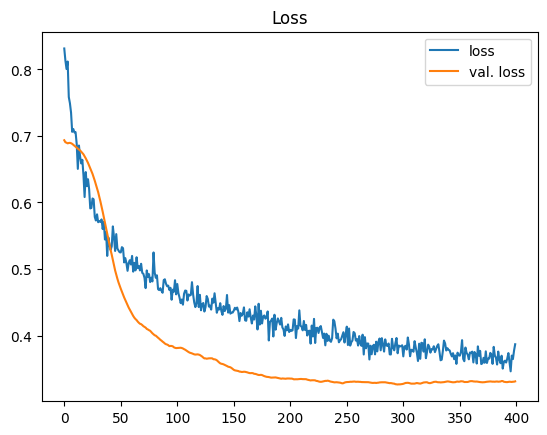

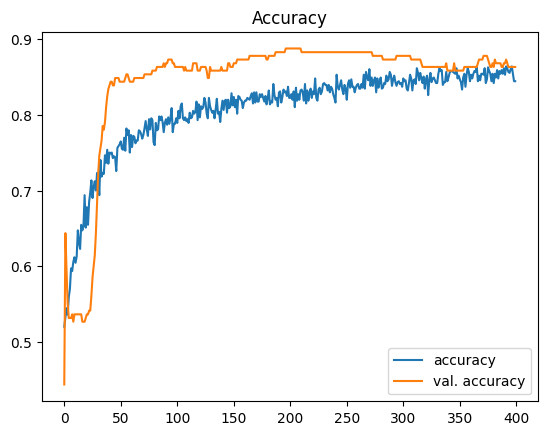

In [19]:
# grafici andamento addestramento modello

# errore
plt.title('Loss')
plt.plot(training_history.history['loss'], label='loss')
plt.plot(training_history.history['val_loss'], label='val. loss')
plt.legend()

plt.show()

# accuratezza
plt.title('Accuracy')
plt.plot(training_history.history['accuracy'], label='accuracy')
plt.plot(training_history.history['val_accuracy'], label='val. accuracy')
plt.legend()

plt.show()

In [20]:
# predizioni di nuovi dati
# il dataset di validazione
# non è stato utilizzato
# durante l'addestramento
predictions = classifier.predict(x_test_norm)
predictions = [0 if p < 0.5 else 1 for p in predictions]

7/7 [==============================] - 0s 6ms/step


In [21]:
Acca = accuracy_score(y_test, predictions)
print('Accuratezza modello:', Acca * 100, '%')

Accuratezza modello: 86.34146341463415 %


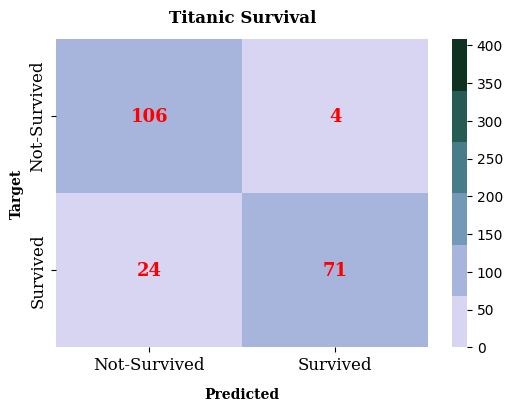

In [22]:
class_names = ['Not-Survived', 'Survived']
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
# Plot confusion matrix
plt.figure(figsize=(6, 4))
# Define the custom palette
custom_palette = sns.cubehelix_palette(start=2)
# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}
font2 = {'family': 'Serif', 'weight': 'bold', 'size': 10}
# Create heatmap with annotations and colormap
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_palette,
                      xticklabels=class_names, yticklabels=class_names,vmin=0,vmax=int(x_train.shape[0]/2),
                      annot_kws={"family": "Serif", 'color':'red','weight': 'bold', 'size': 13})
# Set x and y labels with the custom font dictionary
heatmap.set_xlabel('Predicted', fontdict=font2)
heatmap.set_ylabel('Target', fontdict=font2)
heatmap.set_title('Titanic Survival', fontdict=font, pad=12)
# Set font properties for tick labels on both axes
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontname='Serif', fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontname='Serif', fontsize=12)
# Create a color bar to indicate the scale
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
# Adjust padding between x-axis label and x-axis ticks
plt.gca().xaxis.labelpad = 10  # Change the value as needed to adjust the space
plt.show()

In [23]:
# Salviamo il modello ed i pesi
nome = "Titanic"+str(round(Acca,4))
model_json = classifier.to_json()
with open(nome+".json", "w") as json_file:
     json_file.write(model_json)
classifier.save_weights(nome+".h5")    

In [24]:
predictions = classifier.predict(pro_test)
predictions = [0 if p < 0.5 else 1 for p in predictions]

14/14 [==============================] - 0s 6ms/step


In [25]:
#posso verificare se i rapporti tra data set di train e di test sono rispettati in modo da verificare anche le previsioni
#distribuzione sesso, distribuzione classi in particolare sono gli elementi più importanti


In [26]:
submission = pd.DataFrame({'PassengerId':test_passengerid,'Survived':predictions})
filename = nome+'_Predictions.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

Saved file: Titanic0.8634_Predictions.csv


In [27]:
df1 = pd.read_csv("Titanic0.8939_Predictions.csv")
#df2 = pd.read_csv("Titanic0.8227_Predictions.csv")
df2 = pd.read_csv(filename)
A = df1["Survived"]
B = df2["Survived"]

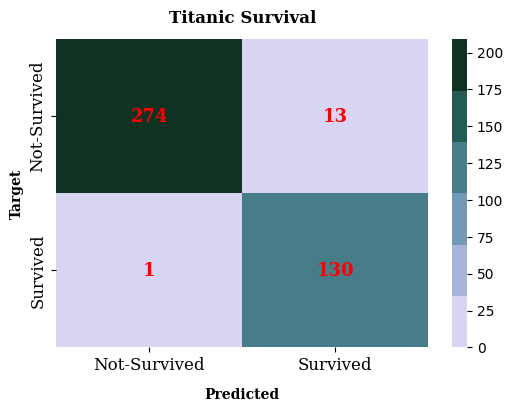

In [28]:
class_names = ['Not-Survived', 'Survived']
# Generate confusion matrix
conf_matrix = confusion_matrix(A, B)
# Plot confusion matrix
plt.figure(figsize=(6, 4))
# Define the custom palette
custom_palette = sns.cubehelix_palette(start=2)
# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}
font2 = {'family': 'Serif', 'weight': 'bold', 'size': 10}
# Create heatmap with annotations and colormap
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_palette,
                      xticklabels=class_names, yticklabels=class_names,vmin=0,vmax=int(df1.shape[0]/2),
                      annot_kws={"family": "Serif", 'color':'red','weight': 'bold', 'size': 13})
# Set x and y labels with the custom font dictionary
heatmap.set_xlabel('Predicted', fontdict=font2)
heatmap.set_ylabel('Target', fontdict=font2)
heatmap.set_title('Titanic Survival', fontdict=font, pad=12)
# Set font properties for tick labels on both axes
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontname='Serif', fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontname='Serif', fontsize=12)
# Create a color bar to indicate the scale
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
# Adjust padding between x-axis label and x-axis ticks
plt.gca().xaxis.labelpad = 10  # Change the value as needed to adjust the space
plt.show()

In [29]:
#memorizzo un file per la data augmentation
df3 = pd.merge(df1, df2, how='inner')
test["PassengerId"] = test_passengerid 
df5 = pd.merge(df3, test, how='inner')
filename = 'train2.csv'
df5.to_csv(filename,index=False)